In [23]:
import numpy as np

n_bath = 7  # number of bath sites

V = 1  # hybridization amplitude
t = 1  # bath hopping amplitude
U = 10  # Impurity onsite repulsion
eps = -U / 2  # Chemical potential for the impurity

# Place the impurity on the first qubit
impurity_index = 0

# One body matrix elements in the "position" basis
h1e = -t * np.diag(np.ones(n_bath), k=1) - t * np.diag(np.ones(n_bath), k=-1)
h1e[impurity_index, impurity_index + 1] = -V
h1e[impurity_index + 1, impurity_index] = -V
h1e[impurity_index, impurity_index] = eps

# Two body matrix elements in the "position" basis
h2e = np.zeros((n_bath + 1, n_bath + 1, n_bath + 1, n_bath + 1))
h2e[impurity_index, impurity_index, impurity_index, impurity_index] = U

In [2]:
import ffsim
import scipy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CPhaseGate, XGate, XXPlusYYGate

n_modes = n_bath + 1
nelec = (n_modes // 2, n_modes // 2)

dt = 0.2
Utar = scipy.linalg.expm(-1j * dt * h1e)


# The reference state
def initial_state(q_circuit, norb, nocc):
    """Prepare an initial state."""
    for i in range(nocc):
        q_circuit.append(XGate(), [i])
        q_circuit.append(XGate(), [norb + i])
    rot = XXPlusYYGate(np.pi / 2, -np.pi / 2)

    for i in range(3):
        for j in range(nocc - i - 1, nocc + i, 2):
            q_circuit.append(rot, [j, j + 1])
            q_circuit.append(rot, [norb + j, norb + j + 1])
    q_circuit.append(rot, [j + 1, j + 2])
    q_circuit.append(rot, [norb + j + 1, norb + j + 2])


# The one-body time evolution
free_fermion_evolution = ffsim.qiskit.OrbitalRotationJW(n_modes, Utar)


# The two-body time evolution
def append_diagonal_evolution(dt, U, impurity_qubit, num_orb, q_circuit):
    """Append two-body time evolution to a quantum circuit."""
    if U != 0:
        q_circuit.append(
            CPhaseGate(-dt / 2 * U),
            [impurity_qubit, impurity_qubit + num_orb],
        )

In [3]:
# Generate the initial state
qubits = QuantumRegister(2 * n_modes, name="q")
init_state = QuantumCircuit(qubits)
initial_state(init_state, n_modes, n_modes // 2)
init_state.draw("mpl", scale=0.4, fold=-1)

d = 8  # Number of Krylov basis states
circuits = []
for i in range(d):
    circ = init_state.copy()
    circuits.append(circ)
    for _ in range(i):
        append_diagonal_evolution(dt, U, impurity_index, n_modes, circ)
        circ.append(free_fermion_evolution, qubits)
        append_diagonal_evolution(dt, U, impurity_index, n_modes, circ)
    circ.measure_all()

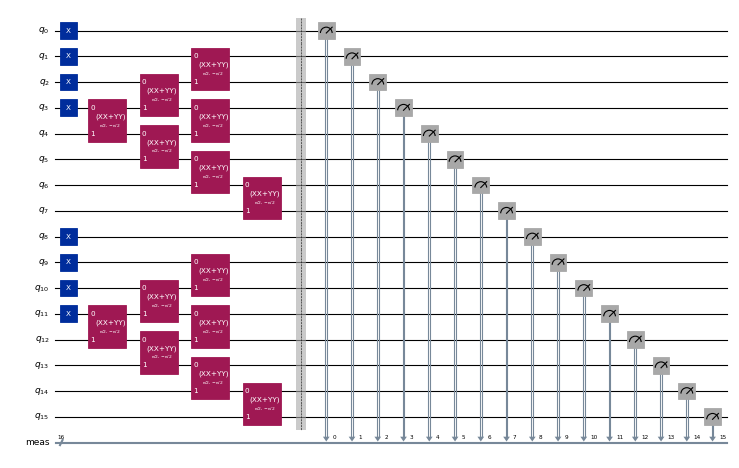

In [4]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

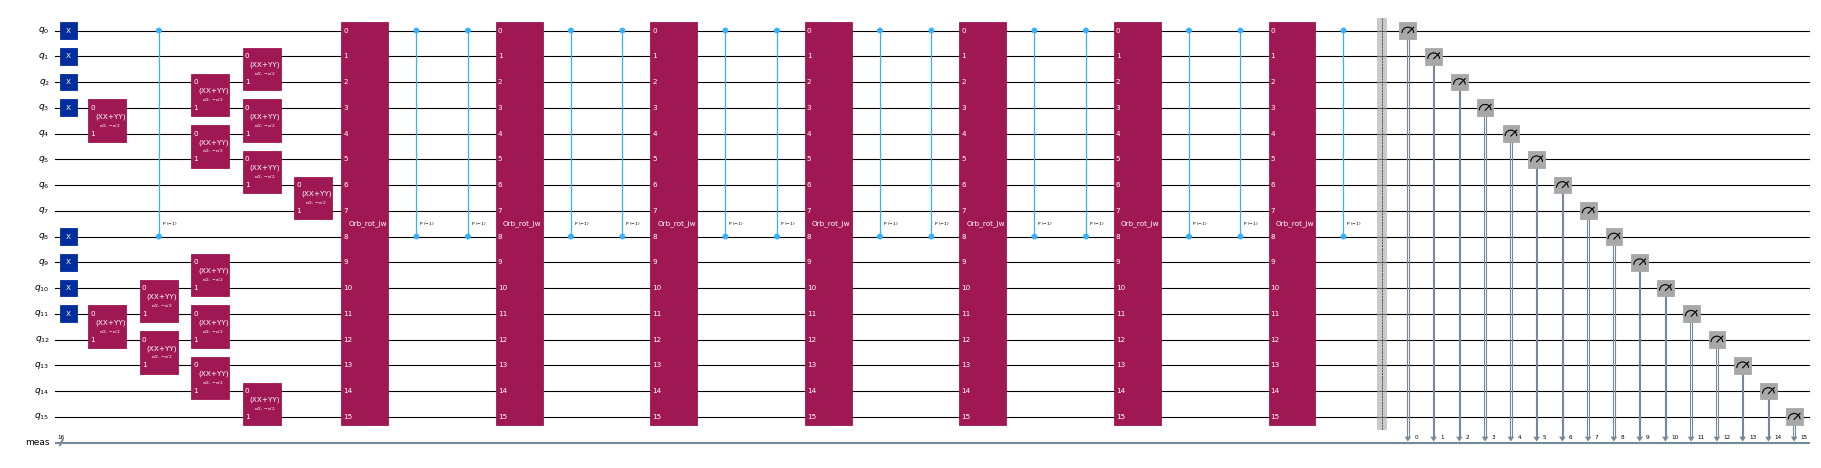

In [5]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

In [18]:
from qiskit_ibm_runtime.fake_provider.backends import FakeSherbrooke
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit_ibm_runtime import QiskitRuntimeService

# backend = FakeSherbrooke()

backend = FakeAlmadenV2()


# service = QiskitRuntimeService(channel='ibm_cloud', token="G_1ihMPCjm6ZX8YOKO8fbc6w7Z6HPpXZLX1YMAmCoHxH", instance="00_Hackathon 2025-1-eu")
# backend = service.least_busy(simulator=False, operational=True)

In [19]:
from qiskit.transpiler import generate_preset_pass_manager

# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuits = pass_manager.run(circuits)

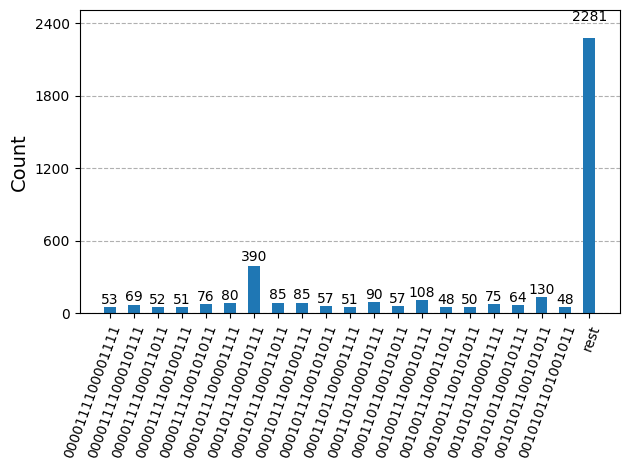

In [20]:
from qiskit.primitives import BitArray
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Sample from the circuits
noisy_sampler = Sampler(backend, options={"simulator": {"seed_simulator": 24}})
job = noisy_sampler.run(isa_circuits, shots=500)

# Combine the counts from the individual Trotter circuits
bit_array = BitArray.concatenate_shots([result.data.meas for result in job.result()])

plot_histogram(bit_array.get_counts(), number_to_keep=20)

In [25]:
bit_array.array

array([[71, 23],
       [23, 45],
       [23, 39],
       ...,
       [77, 77],
       [43, 75],
       [53, 75]], shape=(4000, 2), dtype=uint8)

In [ ]:
import numpy as np

np.save("bit_array_lattice.npy", bit_array.array)

In [26]:
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


rng = np.random.default_rng(24)
result = diagonalize_fermionic_hamiltonian(
    h1e,
    h2e,
    bit_array,
    samples_per_batch=300,
    norb=n_modes,
    nelec=nelec,
    num_batches=3,
    max_iterations=10,
    symmetrize_spin=True,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -11.329922234402336
		Subspace dimension: 1600
	Subsample 1
		Energy: -11.487182137251244
		Subspace dimension: 1296
	Subsample 2
		Energy: -12.208025095053145
		Subspace dimension: 1764
Iteration 2
	Subsample 0
		Energy: -12.4172583711041
		Subspace dimension: 1936
	Subsample 1
		Energy: -12.21621309717109
		Subspace dimension: 1849
	Subsample 2
		Energy: -12.208025095053141
		Subspace dimension: 1764
Iteration 3
	Subsample 0
		Energy: -12.543070554233708
		Subspace dimension: 2025
	Subsample 1
		Energy: -12.4172583711041
		Subspace dimension: 1936
	Subsample 2
		Energy: -12.4172583711041
		Subspace dimension: 1936
Iteration 4
	Subsample 0
		Energy: -12.543070554233708
		Subspace dimension: 2025
	Subsample 1
		Energy: -12.543070554233704
		Subspace dimension: 2025
	Subsample 2
		Energy: -12.543070554233708
		Subspace dimension: 2025


Exact energy: -13.42249
SQD energy: -12.54307
Absolute error: 0.87942


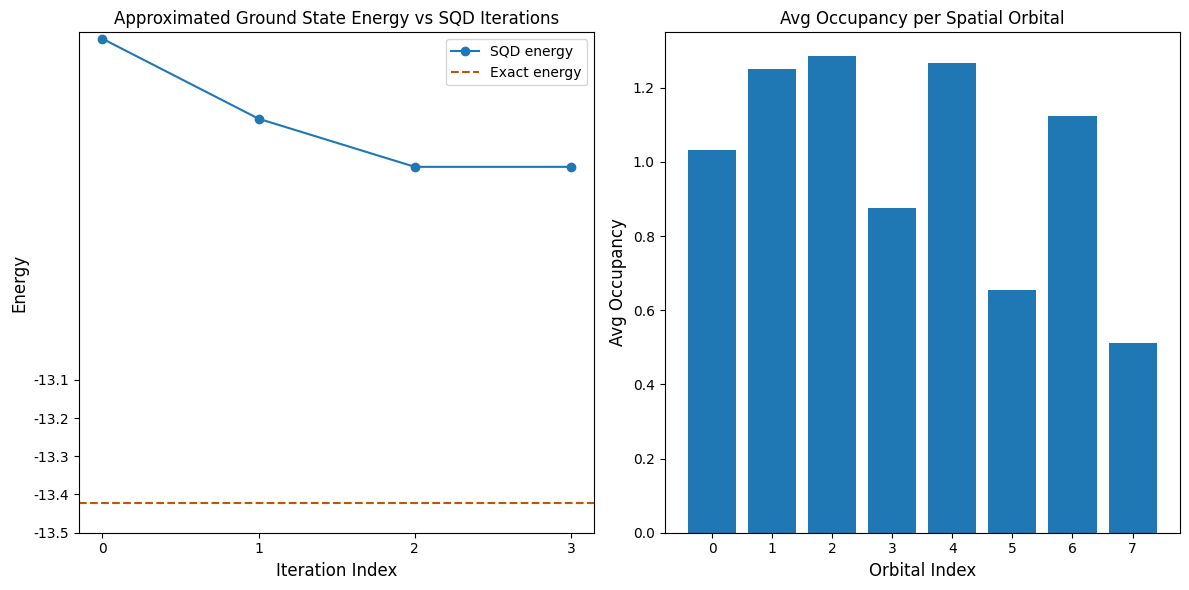

In [22]:
import matplotlib.pyplot as plt

exact_energy = -13.422491814605827
min_es = [min(result, key=lambda res: res.energy).energy for result in result_history]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])

# Data for energies plot
x1 = range(len(result_history))
yt1 = list(np.arange(-13.5, -13.1, 0.1))
ytl = [f"{i:.1f}" for i in yt1]

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, min_es, label="SQD energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(ytl)
axs[0].axhline(y=exact_energy, color="#BF5700", linestyle="--", label="Exact energy")
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f}")
print(f"SQD energy: {min_e:.5f}")
print(f"Absolute error: {abs(min_e - exact_energy):.5f}")
plt.tight_layout()
plt.show()